In [1]:
import torch
from snn_delays.snn import SNN
from snn_delays.experimental_models.snn_binary import TH_BinarySNN, BinarySNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.train_utils import train, get_device, propagate_batch
from snn_delays.utils.visualization_utils import plot_raster
from snn_delays.utils.test_behavior import tb_save_max_last_acc
import matplotlib.pyplot as plt

device = get_device()

# For reproducibility
torch.manual_seed(10)

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
### DATASET

# Parameters
dataset = 'nmnist'
total_time = 50
batch_size = 1024

# Resized dataloader
# DATASET
DL = DatasetLoader(dataset=dataset,
                   caching='gpu',
                   num_workers=0,
                   batch_size=batch_size,
                   total_time=total_time, 
                   sensor_size_to=17)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

[Downsample(time_factor=1, spatial_factor=0.5, sensor_size=None, target_size=None), ToFrame(sensor_size=(17, 17, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]
<class 'list'>


In [3]:
#snn_full = ModelLoader('full_weights_stmnist50_SNN_l1_1d1.t7_874820143884892_max_92epoch','exp_snn2chip', batch_size, device, True) # without bias
snn_full = ModelLoader('full_weights_17_alpha1_(64, 1)nmnist50_l1_1d1.t7_9668_max_10epoch','exp_snn2chip_nmnist', batch_size, device, True) # with bias
snn_full.test(train_loader)

### SPIKING NEURAL NETWORK
structure = snn_full.structure
dataset_dict["time_ms"] = 1
loss_fn = snn_full.loss_fn

print(loss_fn)

binary_mode = 'binary'

snn = BinarySNN(dataset_dict=dataset_dict, structure=structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal', binary_mode=binary_mode,
          reset_to_zero=True, win=total_time, bias=False,
          loss_fn=loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn.set_network()

snn.input2spike_th = None

#snn.to(device)
snn.model_name = 'binary_' + snn.model_name

if snn_full.bias:
    weight_taus = [(name, w) for name, w  in snn.named_parameters() if 'th' not in name]
    weight_taus_origin = [(name, w) for name, w  in snn_full.named_parameters() if 'th' not in name]
else:
    weight_taus = [(name, w) for name, w  in snn.named_parameters() if 'th' not in name and 'bias' not in name]
    weight_taus_origin = [(name, w) for name, w  in snn_full.named_parameters() if 'th' not in name]

for (name_src, param_src), (name_dst, param_dst) in zip(weight_taus_origin, weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

print(weight_taus)

snn.to(device)

num_epochs = 60
lr = 1e-3
ckpt_dir = 'exp_snn2chip_nmnist'


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1
Delta t: 0.02 ms
mean of normal: 6.907255237315501
Instance of <class 'snn_delays.snn.SNN'> loaded successfully
Test Loss: 0.07043794978220584
Avg spk_count per neuron for all 50 time-steps 10.602968215942383
Avg spk per neuron per layer [10.602966927083333]
Test Accuracy of the model on the test samples: 98.025

mem_sum

[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1
Delta t: 0.02 ms
mean of normal: 6.907255237315501
[('tau_m_1', Parameter containing:
tensor([8.3153, 7.5862, 8.0883, 5.3158, 7.4129, 7.2325, 7.0971, 7.3546, 6.1455,
        7.8264, 6.1847, 8.3636, 6.4114, 5.4601, 6.2126, 6.9328, 6.1456, 6.0310,
        7.1311, 6.0820, 6.1531, 7.0186, 7.2238, 6.5217, 6.6586, 6.9802, 6.9965,
        7.5697, 6.6808, 6.7410, 6.8216, 8.3802, 7.6465, 6.6871, 7.3853, 5.2978,
        6.8579, 6.0557, 8.4395,

In [4]:
train(snn, train_loader, test_loader, lr, num_epochs, dropout=0.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(10, 0.95), test_every=1, freeze_taus=True)

training binary_nmnist50_l1_1d1.t7 for 30 epochs...
Epoch [1/30], learning_rates 0.001000, 0.100000
Step [19/58], Loss: 0.44273
l1_score: 0
Step [38/58], Loss: 0.46016
l1_score: 0
Step [57/58], Loss: 0.42835
l1_score: 0
Time elasped: 15.861579895019531
Test Loss: 0.45480144023895264
Avg spk_count per neuron for all 50 time-steps 21.096479415893555
Avg spk per neuron per layer [21.0964796875]
Test Accuracy of the model on the test samples: 86.680

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp_snn2chip_nmnist
Epoch [2/30], learning_rates 0.000857, 0.085737
Step [19/58], Loss: 0.46625
l1_score: 0
Step [38/58], Loss: 0.55297
l1_score: 0
Step [57/58], Loss: 0.43644
l1_score: 0
Time elasped: 16.101734161376953
Test Loss: 0.42158153355121614
Avg spk_count per neuron for all 50 time-steps 20.70973777770996
Avg spk per neuron per layer [20.7097390625]
Test Accuracy of the model on the test samples: 87.870

Model saved in  C:\Users\Alberto\OneDrive

In [6]:
snn_full.f0_f1

Linear(in_features=200, out_features=64, bias=False)

Test Loss: 0.33007449805736544
Avg spk_count per neuron for all 50 time-steps 19.284345626831055
Avg spk per neuron per layer [19.2843453125]
Test Accuracy of the model on the test samples: 90.010


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
tensor(0.3048, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5035, device='cuda:0', grad_fn=<MeanBackward0>)


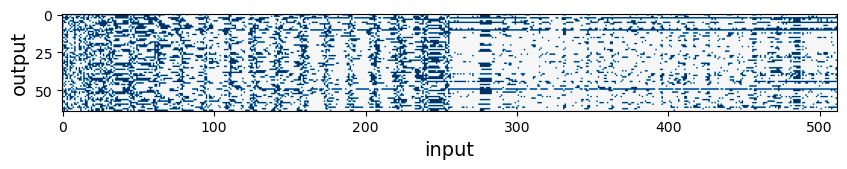

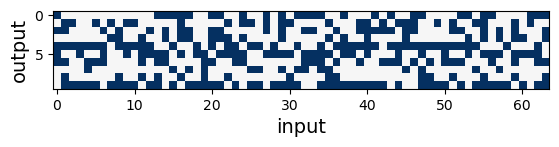

Test Loss: 0.3304518938064575
Avg spk_count per neuron for all 50 time-steps 19.284345626831055
Avg spk per neuron per layer [19.2843453125]
Test Accuracy of the model on the test samples: 90.010



In [11]:
from snn_delays.utils.train_utils import copy_snn
from snn_delays.utils.visualization_utils import plot_param, plot_distributions

# snn_test = copy_snn(snn, batch_size)
# snn_test.debug = True
a, b = snn.test(test_loader)

snn_test = SNN(dataset_dict=dataset_dict, structure=structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal',
          reset_to_zero=True, win=total_time,
          loss_fn=loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn_test.set_network()

weight_taus = [(name, w) for name, w  in snn_test.named_parameters() if 'th' not in name]
for (name_src, param_src), (name_dst, param_dst) in zip(snn.named_parameters(), weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

w_params = [w for name, w  in snn_test.named_parameters() if 'f' in name]

for w in w_params:
    scale = w.abs().mean()
    print(scale)
    if binary_mode == 'binary':
        w.data = (w.data > 0.0).float().mul(scale).mul(0.3)
    #w.data = (w.data > 0.0).float().mul(scale)
    elif binary_mode == 'sign':
        w.data = w.data.mul(scale).sign().mul(scale)
    elif binary_mode == 'relu':
        w.data = w.data.clamp(0, 1).mul(scale)
        #w.data = w.data
    #w.data = (w.data > 0.0).float().mul(scale*0.3)


plt.figure(figsize=(10,10))
for w in w_params:
    plot_param(w, '2D')
    plt.show()

a, b =snn_test.test(test_loader)


### Loading best performing binary model and extraction of weights and states

In [4]:
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.train_utils import train, get_device, propagate_batch
from snn_delays.utils.visualization_utils import plot_raster

model_name = 'binary_nmnist50_l1_1d1.t7_9232_max_56epoch'
ckpt_dir = 'exp_snn2chip_nmnist'
snn = ModelLoader(model_name, ckpt_dir, 1024, 'cuda', True)


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1
Delta t: 0.02 ms
mean of normal: 6.907255237315501
Instance of <class 'snn_delays.experimental_models.snn_binary.BinarySNN'> loaded successfully


Test Loss: 0.27102389484643935
Avg spk_count per neuron for all 50 time-steps 19.57398796081543
Avg spk per neuron per layer [19.5739890625]
Test Accuracy of the model on the test samples: 92.320


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1
Delta t: 0.02 ms
mean of normal: 6.907255237315501
tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5724, device='cuda:0', grad_fn=<MeanBackward0>)


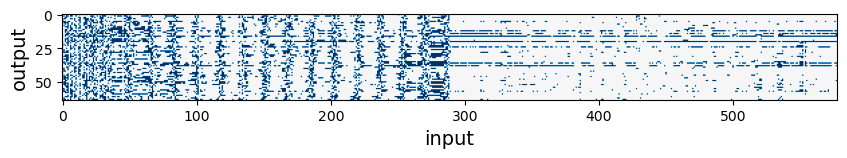

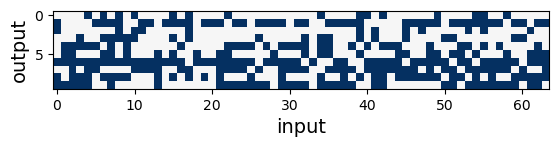

Test Loss: 0.2708389684557915
Avg spk_count per neuron for all 50 time-steps 19.57398796081543
Avg spk per neuron per layer [19.5739890625]
Test Accuracy of the model on the test samples: 92.320



In [39]:
from snn_delays.utils.train_utils import copy_snn
from snn_delays.utils.visualization_utils import plot_param, plot_distributions

# snn_test = copy_snn(snn, batch_size)
# snn_test.debug = True
aa, bb = snn.test(test_loader)

snn_test = SNN(dataset_dict=dataset_dict, structure=structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal',
          reset_to_zero=True, win=total_time,
          loss_fn=loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn_test.set_network()

weight_taus = [(name, w) for name, w  in snn_test.named_parameters() if 'th' not in name]
for (name_src, param_src), (name_dst, param_dst) in zip(snn.named_parameters(), weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

w_params = [w for name, w  in snn_test.named_parameters() if 'f' in name]

for w in w_params:
    scale = w.abs().mean()
    print(scale)
    if binary_mode == 'binary':
        w.data = (w.data > 0.0).float().mul(scale).mul(0.3)
    #w.data = (w.data > 0.0).float().mul(scale)
    elif binary_mode == 'sign':
        w.data = w.data.mul(scale).sign().mul(scale)
    elif binary_mode == 'relu':
        w.data = w.data.clamp(0, 1).mul(scale)
        #w.data = w.data
    #w.data = (w.data > 0.0).float().mul(scale*0.3)


plt.figure(figsize=(10,10))
for w in w_params:
    plot_param(w, '2D')
    plt.show()

a, b =snn_test.test(test_loader)

In [40]:
w_params

[Parameter containing:
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1995, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1995,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.1995,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1995, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1995, 0.1995,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.1717, 0.0000, 0.1717, 0.0000, 0.1717,
          0.0000, 0.1717, 0.0000, 0.0000, 0.0000, 0.0000, 0.1717, 0.0000, 0.1717,
          0.0000, 0.0000, 0.0000, 0.0000, 0.1717, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1717, 0.0000,
          0.0000, 0.0000, 0.0000, 0.1717, 0.1717, 0.0000, 0.1717, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.1717, 0.0000, 0.0000, 0.0000, 0.0000,
          0

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


<Axes: xlabel='Time (ms)', ylabel='Neuron'>

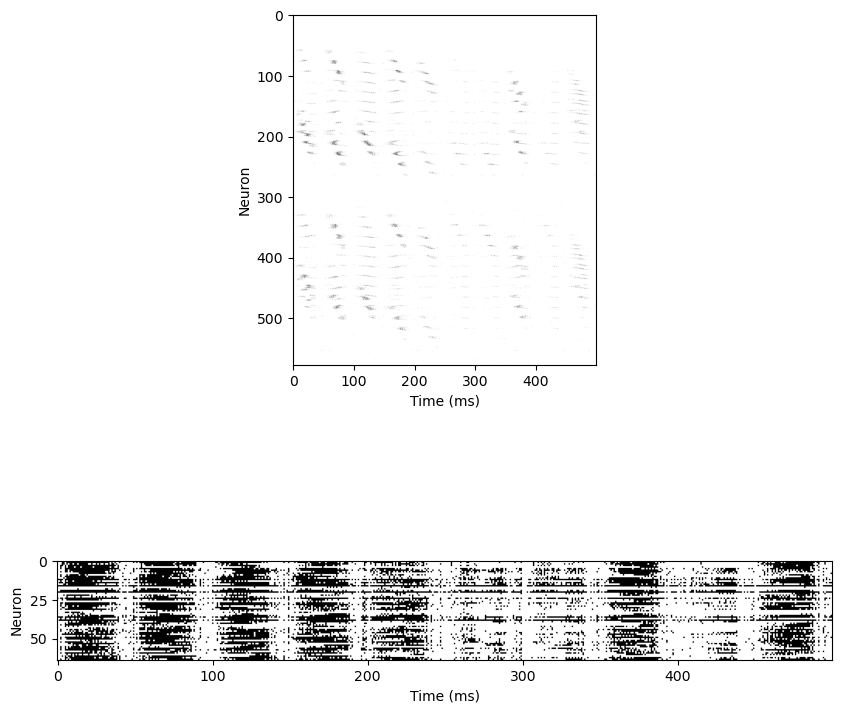

In [41]:
from snn_delays.utils.visualization_utils import plot_raster
plt.figure(figsize=(10,10))
plt.subplot(211)
plot_raster(snn, 'input', 10)
plt.subplot(212)
plot_raster(snn, 'f1', 10)

In [49]:
mems_out = snn_test.mem_state['output'][:, :10, :].permute(1, 0, 2).reshape(500, 10)

Text(0.5, 1.0, 'membrane potentials')

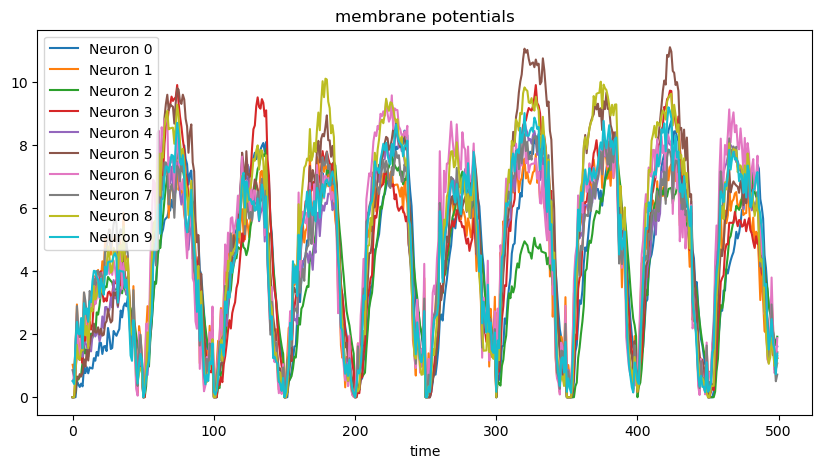

In [50]:
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(mems_out.cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
    plt.legend()
plt.xlabel('time')
plt.title('membrane potentials')

Text(0.5, 1.0, 'softmax of membrane potentials')

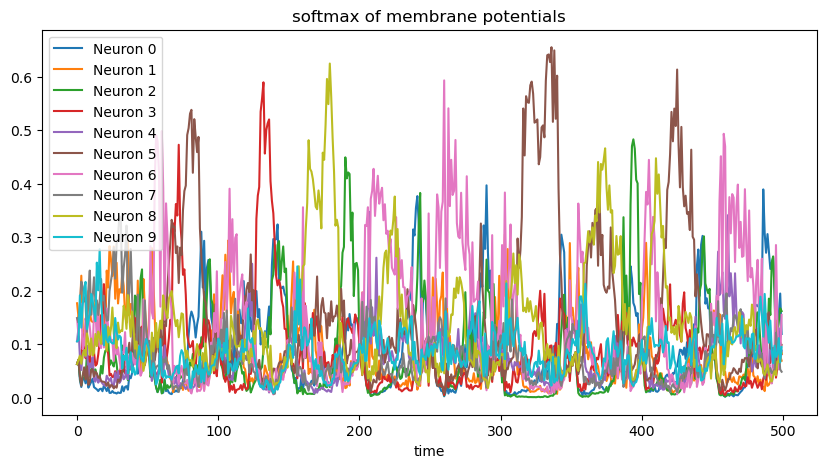

In [51]:
soft_mems_out = torch.softmax(mems_out, dim=1) 

plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(soft_mems_out.cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
    plt.legend()
plt.xlabel('time')
plt.title('softmax of membrane potentials')

In [46]:
# predictions
bb[:10]

[4, 2, 2, 6, 0, 6, 6, 1, 2, 6]